In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/Shared drives/Data Mining Group 2/Utils/jay_utils.py" ./utils.py

!pip install python-dotenv
!pip install catboost

In [ ]:
%matplotlib inline

import os
import time

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (20, 20)


from tqdm import tqdm_notebook
from tqdm import notebook
from tqdm.notebook import tqdm_notebook
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

In [ ]:
DRIVE_DIR = "/content/drive/Shared drives/Data Mining Group 2/Dataset/unzipped_for_colab"
AUDIO_DIR = DRIVE_DIR + "/fma_medium/"

tracks_ld = utils.load(DRIVE_DIR + '/fma_metadata/tracks.csv')
features_ld = utils.load(DRIVE_DIR + '/fma_metadata/features.csv')
# echonest_ld = utils.load(DRIVE_DIR + '/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features_ld.index, tracks_ld.index)
# assert echonest_ld.index.isin(tracks_ld.index).all()

# tracks_ld.shape, features_ld.shape, echonest_ld.shape
tracks_ld.shape, features_ld.shape

((106574, 52), (106574, 518))

In [ ]:
print(type(tracks_ld))
print(type(features_ld))
features_ld.head()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


feature    chroma_cens                      ...       zcr                    
statistics    kurtosis                      ...       min      skew       std
number              01        02        03  ...        01        01        01
track_id                                    ...                              
2             7.180653  5.230309  0.249321  ...  0.000000  2.089872  0.061448
3             1.888963  0.760539  0.345297  ...  0.000000  1.716724  0.069330
5             0.527563 -0.077654 -0.279610  ...  0.000000  2.193303  0.044861
10            3.702245 -0.291193  2.196742  ...  0.000000  3.542325  0.040800
20           -0.193837 -0.198527  0.201546  ...  0.000977  3.189831  0.030993

[5 rows x 518 columns]

In [ ]:
subset = tracks_ld.index[tracks_ld['set', 'subset'].isin(['medium', 'small'])]

assert subset.isin(tracks_ld.index).all()
assert subset.isin(features_ld.index).all()
print(type(subset))
print(subset)
print(subset.isin(tracks_ld.index).all())
tracks = tracks_ld.loc[subset]
features_all = features_ld.loc[subset]
print(tracks, type(tracks))
print(features_all, type(features_all))

<class 'pandas.core.indexes.numeric.Int64Index'>
Int64Index([     2,      3,      5,     10,    134,    136,    139,    140,
               141,    148,
            ...
            155292, 155293, 155294, 155295, 155296, 155297, 155298, 155306,
            155307, 155314],
           dtype='int64', name='track_id', length=25000)
True
            album                      ... track                 
         comments        date_created  ...  tags            title
track_id                               ...                       
2               0 2008-11-26 01:44:45  ...    []             Food
3               0 2008-11-26 01:44:45  ...    []     Electric Ave
5               0 2008-11-26 01:44:45  ...    []       This World
10              0 2008-11-26 01:45:08  ...    []          Freeway
134             0 2008-11-26 01:44:45  ...    []     Street Music
...           ...                 ...  ...   ...              ...
155297          0 2017-03-30 09:50:32  ...    []    Nebula Reborn
1552

In [ ]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']
print(train, type(train), train.shape)
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

# training_features = features_all[features_all.index == train]
training_set = features_all[features_all.index.isin(train)]
test_set = features_all[features_all.index.isin(test)]
val_set = features_all[features_all.index.isin(val)]



Int64Index([     2,      3,      5,     10,    134,    136,    139,    140,
               141,    190,
            ...
            155292, 155293, 155294, 155295, 155296, 155297, 155298, 155306,
            155307, 155314],
           dtype='int64', name='track_id', length=19922) <class 'pandas.core.indexes.numeric.Int64Index'> (19922,)
19922 training examples, 2505 validation examples, 2573 testing examples


In [ ]:
features_all.columns
features_ld.columns
features_all.iloc[:, 0]
print(features_all.index)

Int64Index([     2,      3,      5,     10,    134,    136,    139,    140,
               141,    148,
            ...
            155292, 155293, 155294, 155295, 155296, 155297, 155298, 155306,
            155307, 155314],
           dtype='int64', name='track_id', length=25000)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import preprocessing
def plot_scree(num_component=100, multi_label=False):
    pca = PCA(n_components=num_component)
    # scaler = StandardScaler(copy=False)
    scaler = MinMaxScaler()
    scaler.fit(training_set)
    X_train_s = scaler.transform(training_set) 
    X_test_s = scaler.transform(test_set)
    X_val_s = scaler.transform(val_set)
    pca.fit(X_train_s)
    print("% Variance captured by various components is :")
    print(pca.explained_variance_ratio_*100)
    X_train_s_pca = pca.fit_transform(X_train_s)
    X_test_s_pca = pca.transform(X_test_s)
    X_val_s_pca = pca.transform(X_val_s)
    percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
    columns = range(1,num_component+1)
    fig = plt.figure(figsize=(30, 10))
    plt.bar(x= range(1,num_component+1), height=percent_variance,tick_label=columns)
    plt.ylabel('Percentate of Variance Explained')
    plt.xlabel('Principal Component')
    plt.title('PCA Scree Plot')
    plt.show()

    # y_train, y_val and y_test
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
        #y = enc.fit_transform(tracks['track', 'genre_top'])
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # get y sets
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])

    return X_train_s_pca, X_val_s_pca, X_test_s_pca, y_train, y_val, y_test, enc

% Variance captured by various components is :
[16.17972365  8.63056121  5.4140818   4.68100868  4.18002885  3.89603869
  3.76453231  3.06312654  2.33880366  2.10882086  1.89111957  1.74143827
  1.66737604  1.46630294  1.30113433  1.23269083  1.1439714   1.1206068
  0.99435119  0.87693114  0.80746104  0.77930704  0.76432596  0.69605014
  0.63420589  0.61031477  0.59458765  0.54108246  0.52657921  0.51425742
  0.47959008  0.44909893  0.43733982  0.4272996   0.41620511  0.39789656
  0.39504956  0.38467792  0.36936115  0.36207721  0.35834159  0.3525838
  0.34704902  0.33769477  0.3218898   0.31691148  0.31139965  0.30578994
  0.29774169  0.29073495  0.2854474   0.27813283  0.27287176  0.27029455
  0.26319127  0.25855968  0.25288131  0.24599048  0.24092035  0.23815788
  0.23224101  0.23072536  0.22903998  0.22384934  0.21452802  0.21121654
  0.21003221  0.20118457  0.19908919  0.19629124  0.19198884  0.18971996
  0.18888243  0.18545743  0.18405782  0.17881406  0.17619497  0.1738006
  0.172

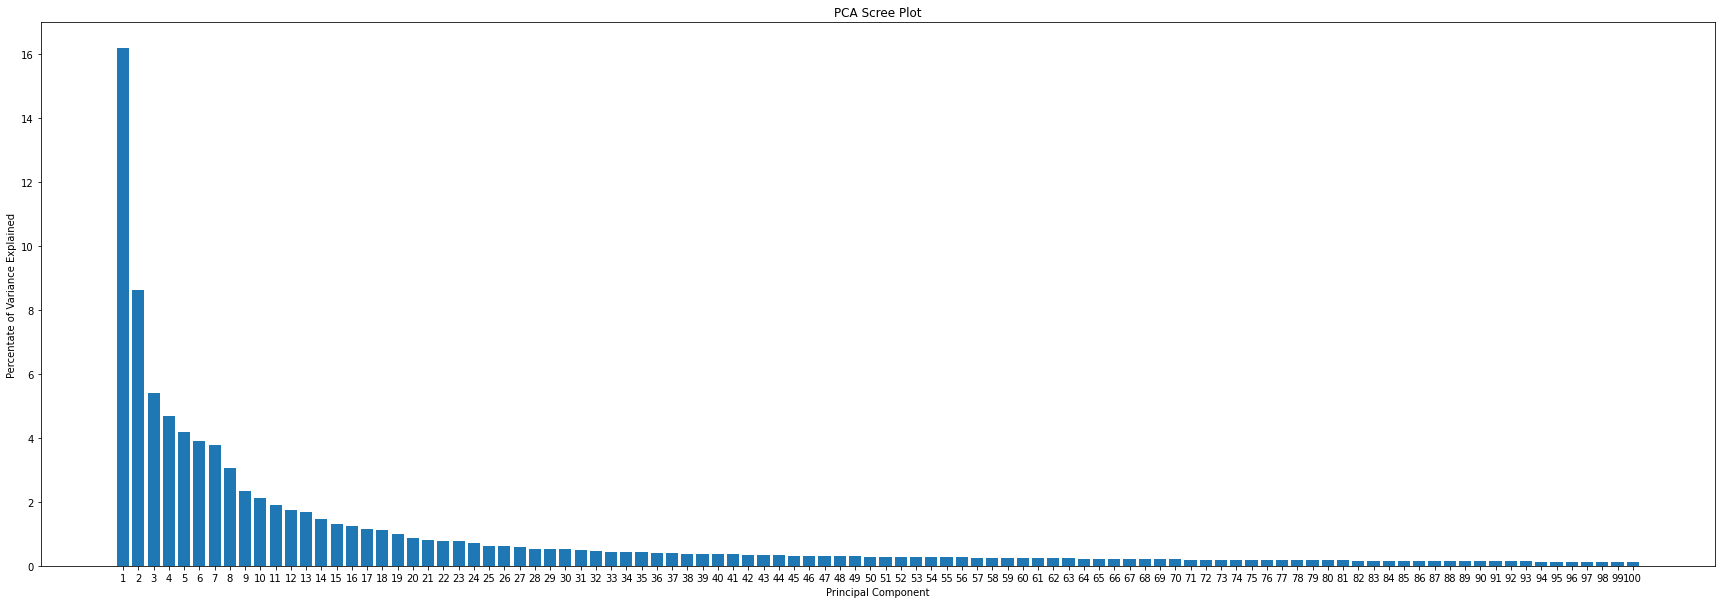

In [ ]:
x_train100=plot_scree(100)

% Variance captured by various components is :
[16.17972365  8.63056121  5.4140818   4.68100868  4.18002885  3.89603869
  3.76453231  3.06312654  2.33880366  2.10882086  1.89111957  1.74143827
  1.66737604  1.46630294  1.30113433  1.23269083  1.1439714   1.1206068
  0.99435119  0.8769311   0.8074609   0.77930548  0.76432557  0.69604764
  0.63419994  0.61030686  0.59457975  0.541068    0.52655933  0.51421997
  0.47950611  0.44878871  0.43719839  0.42695256  0.41548803  0.3967913
  0.39083632  0.38393725  0.36740777  0.36014596]


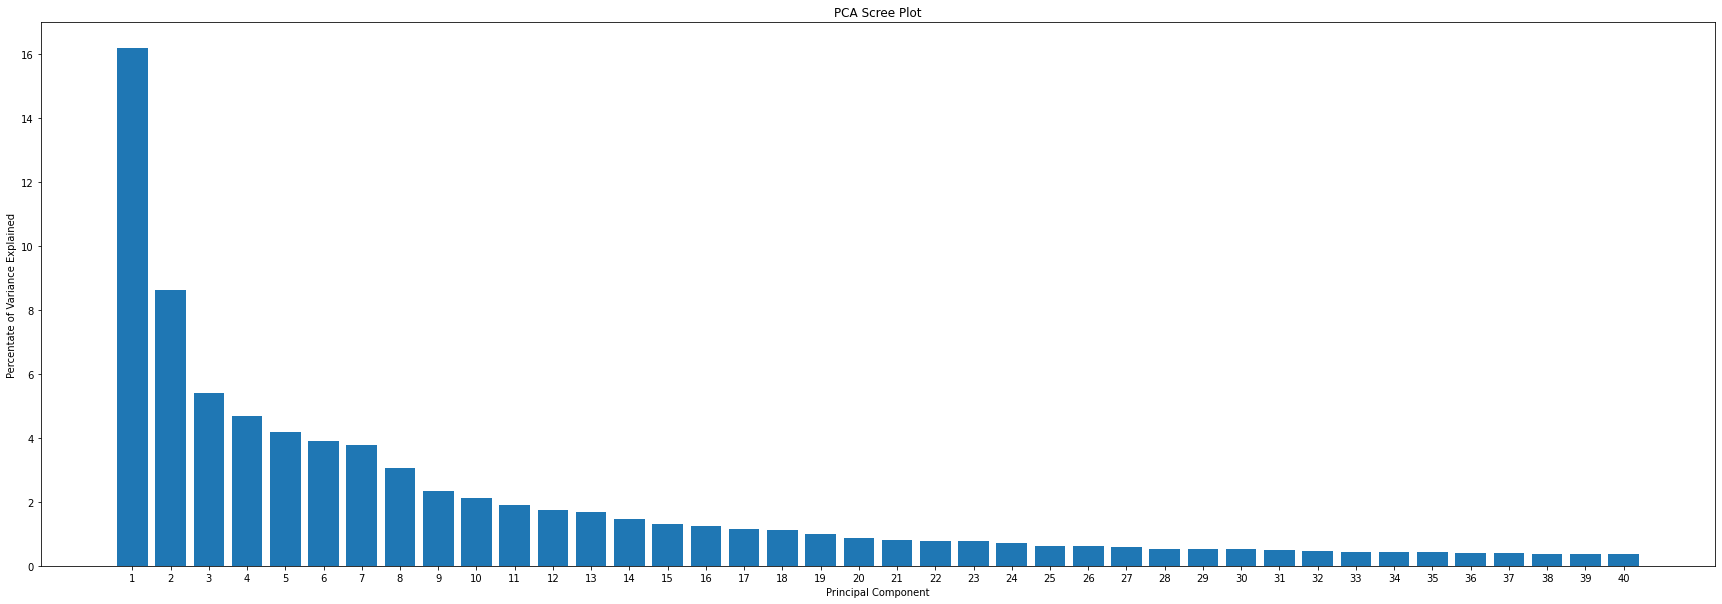

In [ ]:
x_train40=plot_scree(40)


% Variance captured by various components is :
[16.17972365  8.63056121  5.4140818   4.68100868  4.18002885  3.89603869
  3.76453231  3.06312654  2.33880366  2.10882086  1.89111957  1.74143826
  1.66737603  1.46630286  1.30113417  1.23269046  1.14397002  1.12060623
  0.99433933  0.87688182]


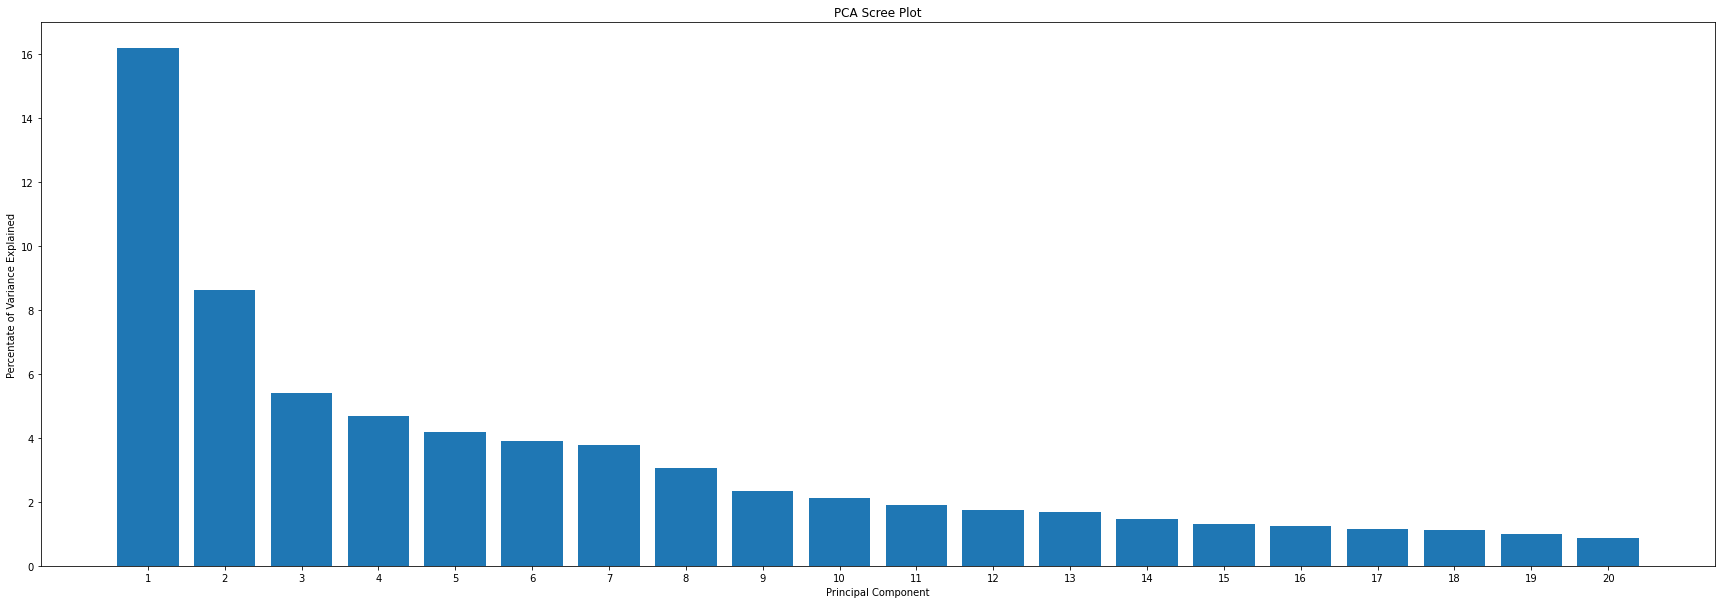

In [ ]:
x_train20=plot_scree(20)

% Variance captured by various components is :
[16.17972365  8.63056121  5.4140818   4.68100868  4.18002885  3.89603869
  3.76453231  3.06312654  2.33880366  2.10882086  1.89111957  1.74143827
  1.66737604  1.46630294  1.30113433  1.23269083  1.1439714   1.1206068
  0.99435119  0.87693114  0.80746104  0.77930701  0.76432596  0.69605015
  0.63420591  0.61031477  0.59458764  0.54108236  0.52657896  0.51425736
  0.47959043  0.44909877  0.43734097  0.42729907  0.41620599  0.39789547
  0.39504932  0.38467645  0.36935817  0.36207862  0.35834576  0.3525834
  0.34704151  0.33769543  0.3218869   0.31691848  0.31140175  0.30580952
  0.29774462  0.29073813  0.28544793  0.27810181  0.27290522  0.27025955
  0.2631697   0.25856281  0.25288938  0.24602809  0.24091645  0.23816618
  0.23229675  0.23073572  0.2291169   0.22387163  0.21425441  0.21144962
  0.20993308  0.20109154  0.19910771  0.19620341  0.19213704  0.19015827
  0.18897118  0.18539055  0.18418229  0.17861383  0.17593861  0.17398849
  0.17

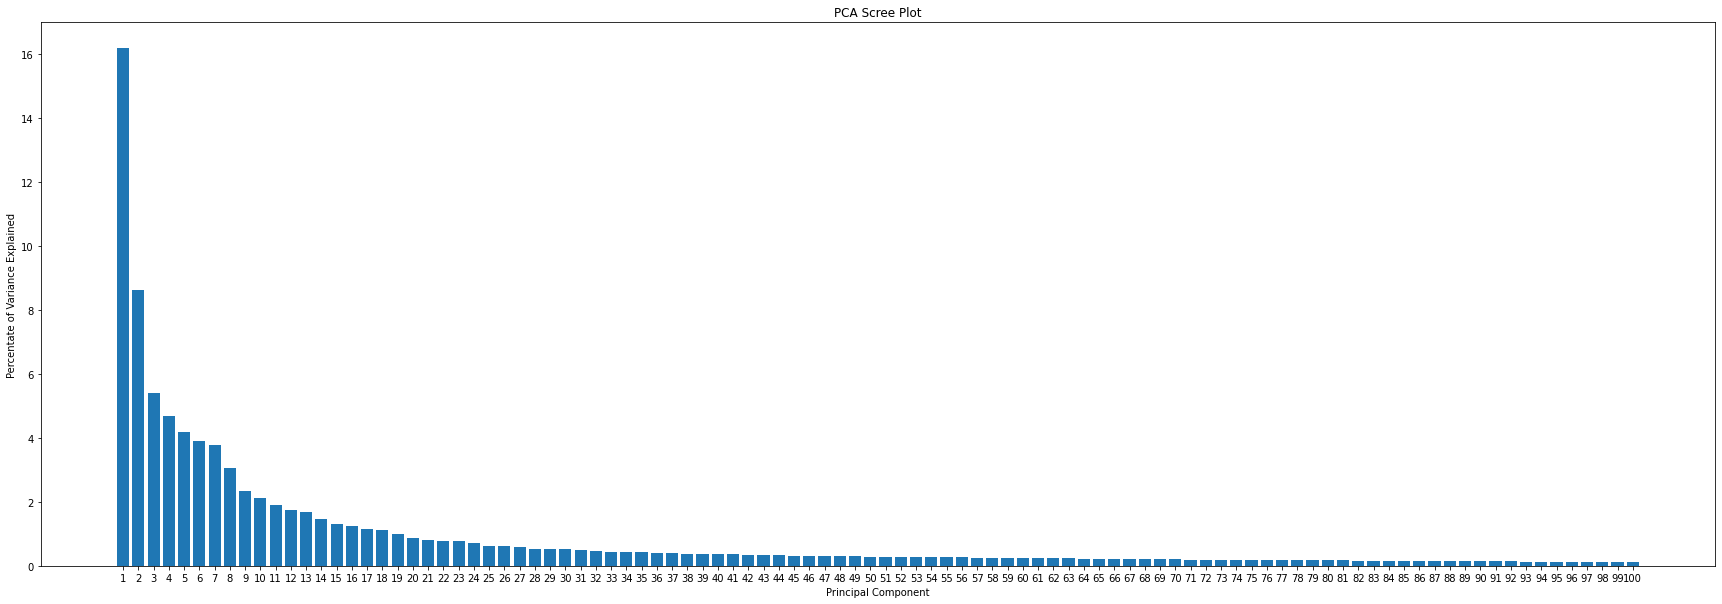

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test, enc = plot_scree(100)

In [ ]:
genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
print('Medium: Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))


Medium: Top genres (16): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']
All genres (151): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 53, 58, 63, 64, 65, 66, 70, 71, 74, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 97, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 137, 138, 166, 167, 169, 171, 172, 174, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 311, 314, 322, 337, 359, 360, 361, 362, 374, 378, 400, 401, 404, 428, 439, 440, 441, 442, 443, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 651, 659, 695, 741, 763, 808, 810, 811, 906, 1032, 1060, 1193, 1235]


In [ ]:
tracks['track', 'genres_all']

track_id
2                    [21]
3                    [21]
5                    [21]
10                   [10]
134                  [21]
               ...       
155297    [107, 18, 1235]
155298          [17, 103]
155306          [17, 103]
155307            [1, 38]
155314           [25, 12]
Name: (track, genres_all), Length: 25000, dtype: object

In [ ]:
x_train_shuffle, y_train_shuffle = shuffle(x_train, y_train, random_state=42)
classifier = CatBoostClassifier()
classifier.fit(x_train_shuffle, y_train_shuffle)

Learning rate set to 0.09217
0:	learn: 2.4950845	total: 722ms	remaining: 12m 1s
1:	learn: 2.3285735	total: 1.4s	remaining: 11m 39s
2:	learn: 2.2074291	total: 2.17s	remaining: 12m 3s
3:	learn: 2.1225849	total: 2.89s	remaining: 11m 59s
4:	learn: 2.0479442	total: 3.59s	remaining: 11m 53s
5:	learn: 1.9781627	total: 4.24s	remaining: 11m 41s
6:	learn: 1.9217892	total: 4.94s	remaining: 11m 40s
7:	learn: 1.8772859	total: 5.59s	remaining: 11m 32s
8:	learn: 1.8341652	total: 6.23s	remaining: 11m 26s
9:	learn: 1.7979633	total: 6.88s	remaining: 11m 21s
10:	learn: 1.7693626	total: 7.56s	remaining: 11m 19s
11:	learn: 1.7344326	total: 8.21s	remaining: 11m 16s
12:	learn: 1.7077478	total: 8.87s	remaining: 11m 13s
13:	learn: 1.6868675	total: 9.57s	remaining: 11m 14s
14:	learn: 1.6678523	total: 10.2s	remaining: 11m 10s
15:	learn: 1.6461919	total: 10.8s	remaining: 11m 5s
16:	learn: 1.6265737	total: 11.4s	remaining: 11m 1s
17:	learn: 1.6092072	total: 12.1s	remaining: 10m 58s
18:	learn: 1.5922491	total: 12.7

In [ ]:
score = classifier.score(x_test, y_test)
print(score)
print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

0.6148464827050136
(19922, 100) (2573, 100) (2505, 100) (19922,) (2573,) (2505,)


Text(0.5, 1.0, 'Medium Dataset, 25 PCA Components')

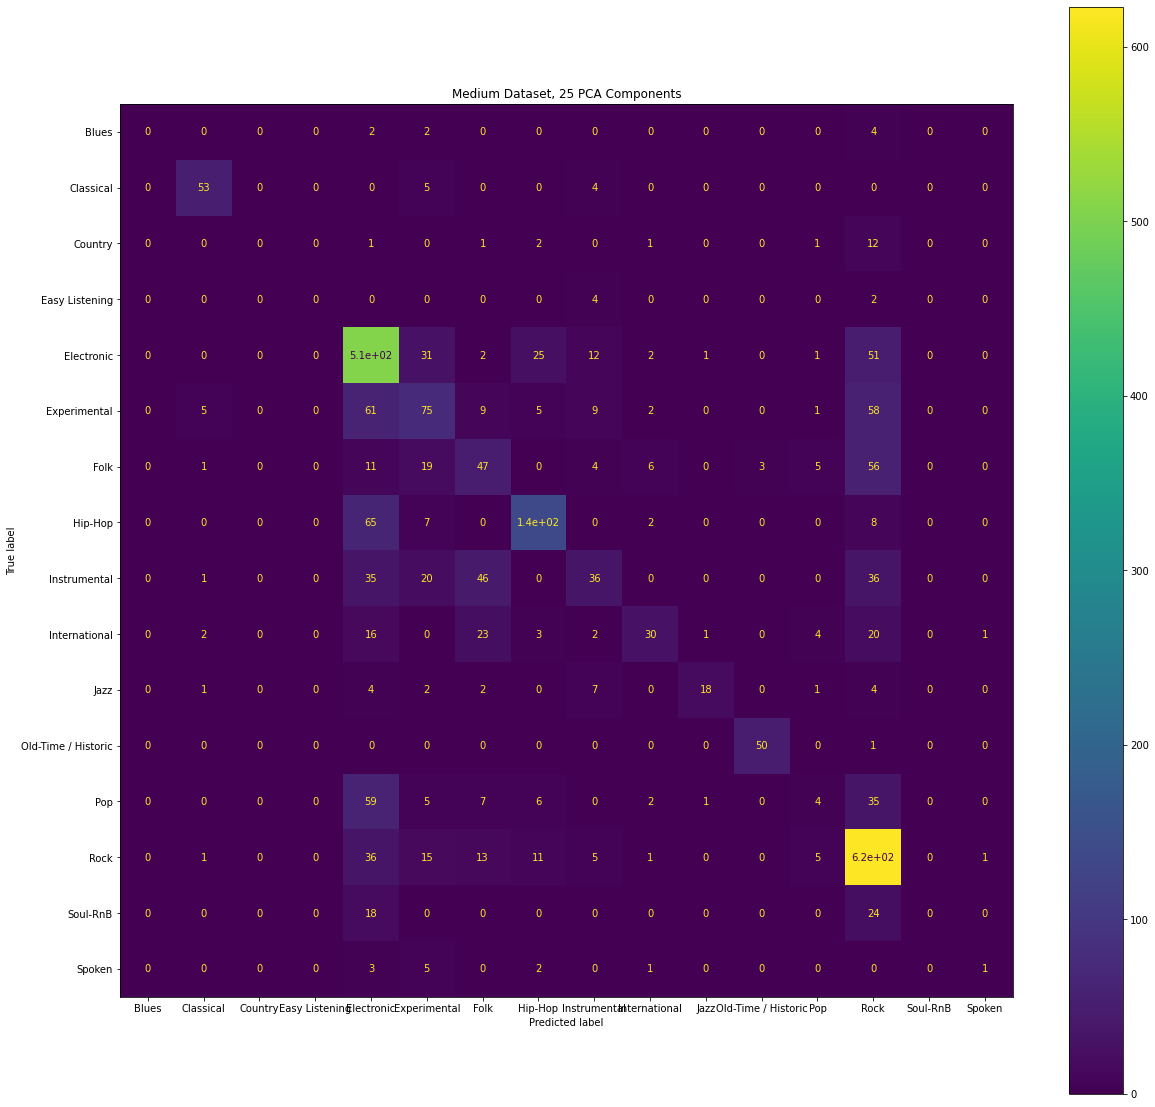

In [ ]:
y_pred = classifier.predict(x_test)
cm_m = confusion_matrix(y_test, y_pred)
cm_display_m = ConfusionMatrixDisplay(cm_m, display_labels=enc.classes_).plot()
cm_display_m.ax_.set_title("Medium Dataset, 25 PCA Components")

In [ ]:
def test_classifiers_features(classifier, dataset, multi_label=False):
    y_train_m, y_val_m, y_test_m, X_train_m, X_val_m, X_test_m, enc_m = pre_process(tracks_m, features_all_m, fset, multi_label)
    # y_train_sm, y_val_sm, y_test_sm, X_train_sm, X_val_sm, X_test_sm, enc_sm = pre_process(tracks_sm, features_all_sm, fset, multi_label)
    
    t = time.process_time()
    clf.fit(X_train_m, y_train_m)
    score_m = clf.score(X_test_m, y_test_m)
    y_pred_m = clf.predict(X_test_m)
    cm_m = confusion_matrix(y_test_m, y_pred_m)
    cm_display_m = ConfusionMatrixDisplay(cm_m, display_labels=enc_m.classes_).plot()
    cm_display_m.ax_.set_title(f'Medium: {clf_name} ({fset_name})')
    scores_m.loc[fset_name, clf_name] = score_m

    # return scores_m, scores_sm, times
    return scores_m, times

def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])


In [ ]:
classifiers = (
    #LogisticRegression(),
    # 'LR': OneVsRestClassifier(LogisticRegression()),
    # 'SVC': OneVsRestClassifier(SVC()),
    # 'MLP': MLPClassifier(max_iter=700),
    ('CatBoost', CatBoostClassifier(logging_level='Silent')),
)
